[bayesian-a-b-testing-with-python-the-easy-guide](https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a)

- To start the post, then, let me point you the practical difference of the bayesian approach from the classical, ‘frequentist’ one: the difference is in the form in which the metric you want to study actually is. For the frequentists, it’s a simple number, while for __bayesians it’s a distribution__.

- Conversion Rate (CR, since now on) of a web page, and the results are in the Table 1, below.

![](https://miro.medium.com/max/299/1*zwlO_-OlPjcvPPCh5xp_Lw.png)

```python
from scipy.stats import beta
import numpy as np
from calc_prob import calc_prob_between

#This is the known data: imporessions and conversions for the Control and Test set
imps_ctrl,convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

# web page views and click beta distribution is the same code as below
# class Bandit:
#   def __init__(self, name):
#     self.clks = 0
#     self.views = 0
#     self.name = name

#   def sample(self):
#     # Beta(1, 1) is the prior
#     a = 1 + self.clks
#     b = 1 + self.views - self.clks
#     return np.random.beta(a, b)

#   def add_click(self):
#     self.clks += 1

#   def add_view(self):
#     self.views += 1

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")
#output: Test option lift Conversion Rates by 59.68% with 98.2% probability.
```

- Each fucntion is built on top of a flat, uninformative one, defined by β(1,1). The more informations (data) we add to this base, the more the function becomes narrower.

- Based on the numbers in Table 1, the Test option performs much better than the Control one: almost 60% uplift, with more than 98% probability of being better.

- 

- In the code I initialized two “Beta” functions, one for each option, feeding them with the numbers we had in the table:

![](https://miro.medium.com/max/257/1*HjtYZngt7sh3Ujcq7xBsow.png)
![](https://miro.medium.com/max/432/1*8CxN7lOhf3ChFg3Mur-6kw.gif)

![](https://miro.medium.com/max/329/1*1aA3Dj4gQwlbFeo7x0ZNFw.png)

[UTMDABTR-005-05](https://www.johndcook.com//UTMDABTR-005-05.pdf)

## in UTMDABTR-005-05

$$
g(a,b,c,d) = \int_{0}^{1}\frac{x^{a-1}(1-x)^{b-1}}{B(a,b)}I_{x}(c,d)dx\\
h(a,b,c,d) = \frac{B(a+c,b+d)}{B(a,b)B(c,d)}\\
h(a,b,c,d) = \frac{\Gamma(a+b)\Gamma(b+d)\Gamma(a+b)\Gamma(c+d)}{\Gamma(a)\Gamma(b)\Gamma(c)\Gamma(d)\Gamma(a+b+c+d)}\\
$$

In [1]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [8]:
from scipy.stats import beta
import numpy as np
# from calc_prob import calc_prob_between

#This is the known data: imporessions and conversions for the Control and Test set
imps_ctrl,convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print ("Test option lift Conversion Rates by {:2.2f}  with {:2.1f}  probability.".format(lift*100,prob*100))
#output: Test option lift Conversion Rates by 59.68% with 98.2% probability.

Test option lift Conversion Rates by 59.68  with 98.2  probability.


AttributeError: 'JointGrid' object has no attribute 'show'

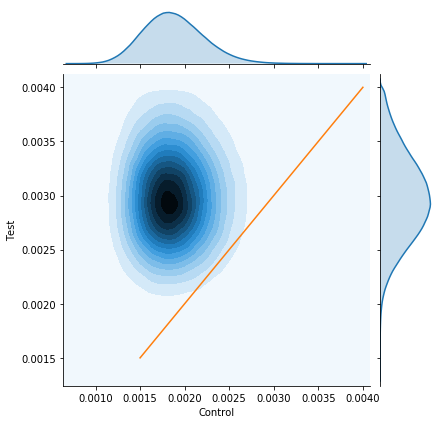

In [12]:
%matplotlib inline 
import seaborn as sns
import pandas as pd
import numpy as np
imps_ctrl,convs_ctrl=16500, 30 
imps_test, convs_test=17000, 50

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

val_C=np.random.beta(a_C, b_C, 1000000)
val_T=np.random.beta(a_T, b_T, 1000000)
vals=np.vstack([val_C, val_T]).T

limit=0.004


df=pd.DataFrame(vals, columns=['Control', 'Test'])
df=df[df['Control']<limit]
df=df[df['Test']<limit]
g=sns.jointplot(x=df.Control, y=df.Test, kind='kde', n_levels=15)
g.ax_joint.plot([0.0015, limit], [0.0015, limit])
